In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from utils.training import *
from utils.utils import *

from models.infersent import *
from models.self_attentive import *
from models.bert import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(font_scale=1.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

# Data

In [4]:
data = pd.read_csv('emotions_short.csv', index_col='Unnamed: 0')
data.head()

,Text,Emotion
0,im grabbing a minute to post i feel greedy wrong,anger
1,i am feeling grouchy,anger
2,i think it s the easiest time of year to feel ...,anger
3,i feel irritated and rejected without anyone d...,anger
4,i already feel like i fucked up though because...,anger


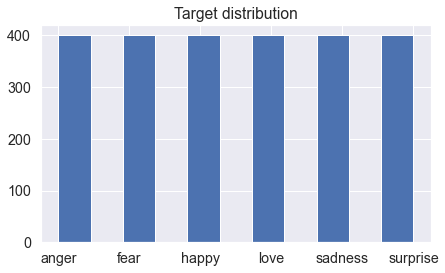

In [4]:
plt.figure(figsize=(7, 4))
plt.title('Target distribution')
plt.hist(data['Emotion'], bins=11);

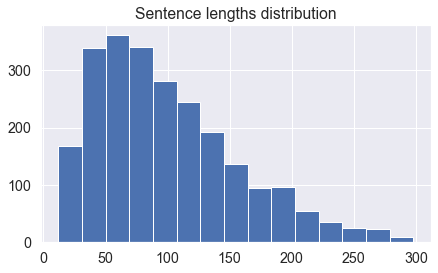

In [5]:
lens = []
for sentence in data['Text']:
    lens.append(len(sentence))

plt.figure(figsize=(7, 4))
plt.title('Sentence lengths distribution')
plt.hist(lens, bins=15);

# Structured-Self-Attentive-Sentence-Embedding

In [6]:
max_len = 150
emb_size = 100

X, y, word2idx, embedding_weights = preprocess_data(data['Text'], data['Emotion'], 
                                                    './GloVe/glove.6B.100d.txt', emb_size, max_len)

train_dataloader, val_dataloader = get_dataloaders(X, y)

0it [00:00, ?it/s]

  0%|          | 0/5562 [00:00<?, ?it/s]

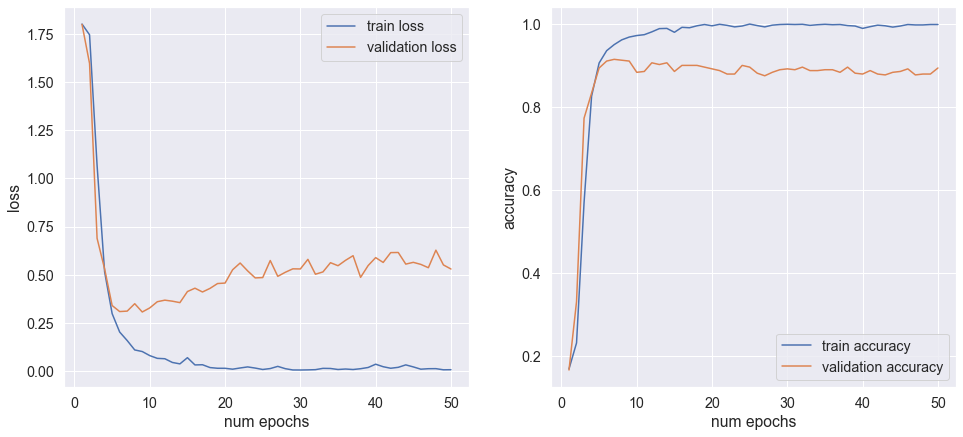

epoch number: 50
time per epoch: 2.566s
validation acc: 89.4
validation loss: 0.529


In [7]:
vocab_size, emb_size = embedding_weights.shape

model = SelfAttentiveClassifierNet(vocab_size, emb_size, 6, pre_embd=embedding_weights).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model, history = train(
    model, criterion, optimizer,
    train_dataloader, val_dataloader, num_epochs=50,
    model_path_to_save='./weights/self_attentive.pth',
    history_path_to_save='./histories/self_attentive.csv'
)

In [8]:
params = [vocab_size, emb_size, 6]

save_embedding_layer(SelfAttentiveClassifierNet, params, 
                     './weights/self_attentive.pth', './weights/self_attentive_embeddings.pth')

Saved!


In [9]:
params = [vocab_size, emb_size]

self_attentive_embeddings = get_embeddings(X, SelfAttentiveNet, params, './weights/self_attentive_embeddings.pth')
save_embeddings(self_attentive_embeddings, './embeddings/self_attentive_embeddings.csv')

  0%|          | 0/2400 [00:00<?, ?it/s]

Saved!


# InferSent

In [6]:
max_len = 150
emb_size = 300

X, y, word2idx, embedding_weights = preprocess_data(data['Text'], data['Emotion'], 
                                                    './GloVe/glove.840B.300d.txt', emb_size, max_len)

train_dataloader, val_dataloader = get_dataloaders(X, y)

0it [00:00, ?it/s]

  0%|          | 0/5562 [00:00<?, ?it/s]

In [7]:
V = 1
MODEL_PATH = './infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': V}

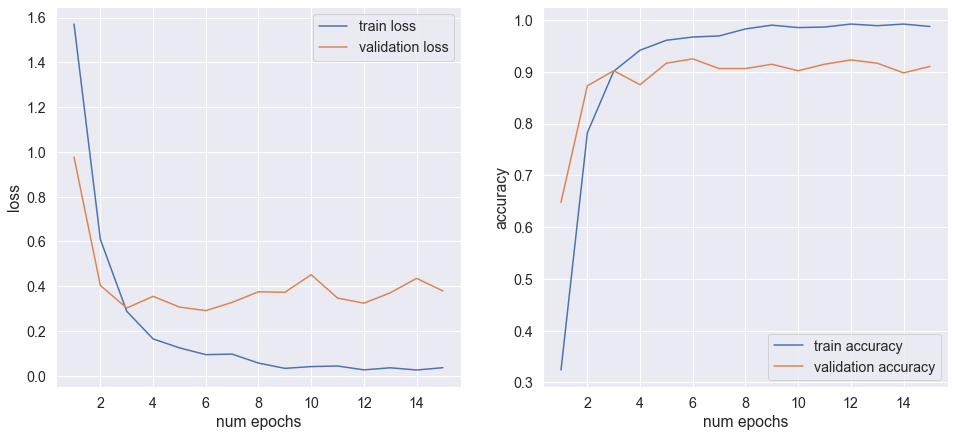

epoch number: 15
time per epoch: 37.12s
validation acc: 91.0
validation loss: 0.379


In [8]:
vocab_size, emb_size = embedding_weights.shape

model = Classifier(vocab_size, emb_size, MODEL_PATH, params_model, 6, 2048, max_len, pre_embd=embedding_weights).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model, history = train(
    model, criterion, optimizer,
    train_dataloader, val_dataloader, num_epochs=15,
    model_path_to_save='./weights/infersent.pth',
    history_path_to_save='./histories/infersent.csv'
)

In [10]:
params = [vocab_size, emb_size, MODEL_PATH, params_model, 6, 2048, max_len]

save_embedding_layer(Classifier, params, './weights/infersent.pth', './weights/infersent_embeddings.pth')

Saved!


In [11]:
params = [vocab_size, emb_size, MODEL_PATH, params_model, max_len]

infersent_embeddings = get_embeddings(X, InferSentNet, params, './weights/infersent_embeddings.pth')
save_embeddings(infersent_embeddings, './embeddings/infersent_embeddings.csv')

  0%|          | 0/2400 [00:00<?, ?it/s]

Saved!


# Bert

In [6]:
train_dataloader, val_dataloader = get_bert_dataloaders(data['Text'], data['Emotion'])

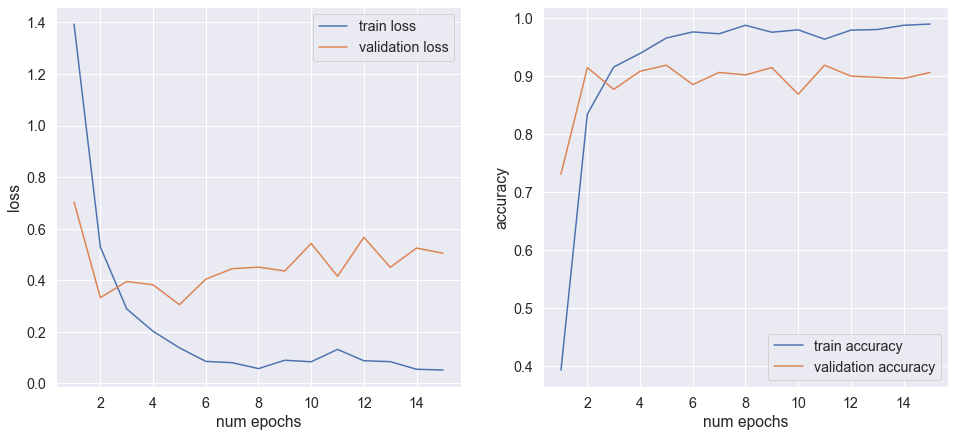

epoch number: 15
time per epoch: 41.421s
validation acc: 90.60000000000001
validation loss: 0.505


In [7]:
model = ClassificationModel(num_classes=6, hidden_size=384).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model, history = bert_training_loop(
    model, criterion, optimizer,
    train_dataloader, val_dataloader, num_epochs=15,
    model_path_to_save='./weights/bert.pth',
    history_path_to_save='./histories/bert.csv'
)

In [8]:
params = [6, 384]

save_embedding_layer(ClassificationModel, params, './weights/bert.pth', './weights/bert_embeddings.pth')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saved!


In [4]:
self_attentive_embeddings = get_bert_embeddings(data['Text'].values, './weights/bert_embeddings.pth')
save_embeddings(self_attentive_embeddings, './embeddings/bert_embeddings.csv')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

Saved!


# Bag-Of-Words

In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Text']).toarray()

columns = ['emb_dim_{}'.format(i + 1) for i in range(X.shape[1])]

pd.DataFrame(X, columns=columns).to_csv('./embeddings/bag_of_words_embeddings.csv', index=False)

# TF-IDF

In [5]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Text']).toarray()

columns = ['emb_dim_{}'.format(i + 1) for i in range(X.shape[1])]

pd.DataFrame(X, columns=columns).to_csv('./embeddings/tf_idf_embeddings.csv', index=False)